# Bishop and Qazaz 1996, Regression with Input Dependent Noise: A Bayesian Treatment

In this notebook, we implement the technique in the above paper, for a dataset
similar to the one in the paper.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Data Model

In [2]:
# ground truth data model (from BISHOP fig 2). Looks like just sin(x)
def data_model(x):
  return np.sin(x)

# variance data model (from BISHOP fig 2)
def variance_model(x):
  return 0.1 + 0.044 * x**2

## Generate ground truth training data

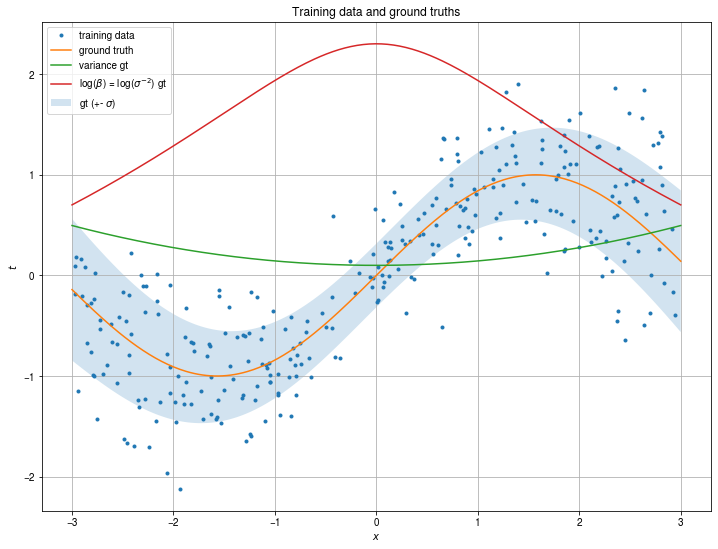

In [3]:
N = 300 # num data points
(x_min, x_max) = (-3, 3) # indep var range

# generate ground truth data
np.random.seed(42)
# training data indep var (x) values
X = np.random.uniform(x_min, x_max, N)
# noise from x-dep variance model
ep = np.array([np.random.normal(0., np.sqrt(variance_model(el))) for el in X])
# training data hypothesis values y(x)
t = data_model(X) + ep

## for plotting ground truth functions ################################################
# ground truth hypothesis
# Xcont = np.linspace(np.min(X), np.max(X), N)
Xcont = np.linspace(x_min, x_max, N)
tcont = data_model(Xcont)

# ground truth for input-dep variance
X_var_cont = variance_model(Xcont)
# ground truth for input-dep stddev = sqrt(variance)
X_stddev_cont = np.sqrt(X_var_cont)
# ground truth for inverse variance, beta
X_invvar_cont = 1. / X_var_cont
# ground truth for log inverse variance, log(beta) = u^T.phi
X_loginvvar_cont = np.log(X_invvar_cont)
#######################################################################################

fig, ax = plt.subplots(figsize=(12, 9))
ax.plot(X, t,'.', label='training data')
ax.plot(Xcont, tcont, label='ground truth')
ax.plot(Xcont, X_var_cont, label='variance gt')
ax.plot(Xcont, X_loginvvar_cont, label=r'log($\beta$) = log($\sigma^{-2}$) gt')
ax.fill_between(Xcont, tcont + X_stddev_cont, tcont - X_stddev_cont,
                alpha=0.2, label='gt (+- $\sigma$)')
ax.set(xlabel=r'$x$', ylabel=r'$t$', title='Training data and ground truths')
ax.legend()
ax.grid()


## Generate Gaussian basis function (gbf) design matrices $\Phi$, $\Psi$

In [4]:
def gen_desmat_gaussian(X, params):
  """
  Generates design matrix with Gaussian basis functions.

  Args:
    X ((N,) array): input data
    params (dict):
      params['mus'] : (M-1,)  array. params['mus'][j] being the center of the
                      jth Gaussian
      params['s'] : double. positive real number, which stands for the width of
                    Gaussians
  Returns:
    Phi((N, M) array): design matrix, with Phi[n, m] = $\phi_m(x_n)$
  """

  s = params['s']
  mus = params['mus']
  # reshape X and mus into column vectors
  X = np.reshape(X, (len(X), 1) )
  mus = np.reshape(mus, (len(mus), 1) )
  Phi = np.zeros((len(X), len(mus) + 1) )
  Phi[:, 0] = np.ones(len(X))  # the 0'th basis fn is a constant
  A = (-2 * (X @ (mus.T)) + X**2) + np.reshape(mus**2, len(mus))
  Phi[:, 1:] = np.exp(-A / (2 * s * s))
  return Phi


# number of basis function for y(x), log inv var
M_w, M_u = 4, 4

# mus are centers of gbfs, s is spacing between gbfs
# 4 w gbfs, w/ edge gbfs at s_w/2 from boundary of data.
mus_w = np.array([-2.25, -0.75, 0.75, 2.25])
s_w = 1.5

# 4 u gbfs, w/ edge gbfs at s_u/2 from boundary of data.
mus_u = np.array([-2.25, -0.75, 0.75, 2.25])
s_u = 1.5

# generate y(x) gbf design matrix Phi from input data X
Phi = gen_desmat_gaussian(X, params={'s':s_w, 'mus':mus_w})
# generate log(beta) gbf design matrix Psi from input data X
Psi = gen_desmat_gaussian(X, params={'s':s_u, 'mus':mus_u})
Phi_test = gen_desmat_gaussian(Xcont, params={'s':s_w, 'mus':mus_w})

## Initialize Bayesian heteroskedastic regression class

For computing evidence and derivatives of evidence wrt $u$.

In [5]:
class BayesianHetRegression:

  def __init__(self, al_w=0.1, al_u=0.1):
    self.al_w = al_w
    self.al_u = al_u
    self.m = None  # posterior mean
    self.S = None  # posterior covariance matrix

  def calc_wmp(self, Phi, Psi, u_mp, t):
    """
    Calculates w_mp, given u_mp

    Args:
      Phi ((N, M_w + 1) array): design matrix for y(x) gt
      Psi ((N, M_u + 1) array): design matrix for for log(beta) gt
      u_mp ((M_u + 1,) array): most probable current value of u weights
      t ((N,) array): target values

    Returns:
      w_mp ((M_w + 1,) array): most probable w vals for the given value of u_mp
    """

    N = np.shape(Phi)[0]
    M_w = np.shape(Phi)[1] - 1
    M_u = np.shape(Psi)[1] - 1

    B = np.diag(np.exp(Psi @ u_mp))

    S = np.linalg.inv(self.al_w * np.identity(M_w + 1) + Phi.T @ B @ Phi)
    w_mp = S @ Phi.T @ B @ t

    return w_mp

  def calc_evidence(self, Phi, Psi, u, t):
    """
    Calculates the evidence M(u)

    Args:
      Phi ((N, M_w + 1) array): design matrix for y(x) gt
      Psi ((N, M_u + 1) array): design matrix for for log(beta) gt
      u ((M_u + 1,) array): current value of u
      t ((N,) array): target values

    Returns:
      evidence (float): evidence for this value of u
    """

    N = np.shape(Phi)[0]
    M_w = np.shape(Phi)[1] - 1
    M_u = np.shape(Psi)[1] - 1

    # w_mp must be evaluated for each new value of u when evidence is calculated
    w_mp = self.calc_wmp(Phi, Psi, u, t)

    B = np.diag(np.exp(Psi @ u))

    A = self.al_w * np.identity(M_w + 1) + (Phi.T) @ B @ Phi

    evidence = 0.5 * (t - Phi @ w_mp).T @ B @ (t - Phi @ w_mp) + \
               0.5 * self.al_u * (u @ u) - 0.5 * np.sum(Psi @ u) + \
               0.5 * np.log(np.linalg.det(A))

    return evidence

  def calc_evidence_der(self, Phi, Psi, u, t):
    """
    Calculates the derivative of the evidence, dM(u) / du, wrt the the components of u

    Args:
      Phi ((N, M_w + 1) array): design matrix for y(x) gt
      Psi ((N, M_u + 1) array): design matrix for for log(beta) gt
      u ((M_u + 1,) array): current value of u
      t ((N,) array): target values

    Returns:
      evidence_der ((M_u + 1,) array): components of the derivative of M(u) wrt
       the (M_u + 1) components of u
    """

    N = np.shape(Phi)[0]
    M_w = np.shape(Phi)[1] - 1
    M_u = np.shape(Psi)[1] - 1

    # w_mp must be evaluated for each new value of u when evidence deriv is calculated
    w_mp = self.calc_wmp(Phi, Psi, u, t)

    B = np.diag(np.exp(Psi @ u))
    A = self.al_w * np.identity(M_w + 1) + Phi.T @ B @ Phi
    A_inv = np.linalg.inv(A)

    evidence_der = np.zeros(M_u + 1)

    for j in range(M_u + 1):
      # deriv of A wrt jth component of u
      dAduj = Phi.T @ np.diag(Psi[:, j]) @ B @ Phi
      evidence_der[j] = \
        0.5 * (t - Phi @ w_mp).T @ np.diag(Psi[:, j]) @ B @ (t - Phi @ w_mp) + \
        self.al_u * u[j] - 0.5 * np.sum(Psi[:, j]) + 0.5 * np.trace(A_inv @ dAduj)

    return evidence_der


est = BayesianHetRegression()

## Optimization

We compare two types of optimization on the evidence $M(u)$. First is a basic
gradient descent. Second is scipy's Nelder-Mead method, which does not use the
gradient.

### 1. Minimize via simple full-batch gradient descent

In [6]:
u_val = np.random.normal(0., 1., size=M_u+1)

maxiter = 25000
train_rate = 0.05
for i in range(maxiter):
  # w_mp = est.calc_wmp(Phi, Psi, u_val, t)
  ev = est.calc_evidence(Phi, Psi, u_val, t) / 50.
  ev_der = est.calc_evidence_der(Phi, Psi, u_val, t) / 50.
  u_val -= train_rate * ev_der

  if i % 1000 == 0:
    it_string = 'iteration ' + str(i) + ': '
    print(it_string + 'evidence = ', ev)

#u_weights = u
#w_weights = est.calc_wmp(Phi, Psi, u_weights, t)

print('\n')
print('u_mp:', u_val) 
print('w_mp (at u_mp)', est.calc_wmp(Phi, Psi, u_val, t))
    

iteration 0: evidence =  4.233471792145345
iteration 1000: evidence =  -1.6263530095458427
iteration 2000: evidence =  -1.6265835233476758
iteration 3000: evidence =  -1.6266349326345735
iteration 4000: evidence =  -1.626648907752618
iteration 5000: evidence =  -1.6266541334199434
iteration 6000: evidence =  -1.6266567578178652
iteration 7000: evidence =  -1.6266583102185752
iteration 8000: evidence =  -1.6266592939791185
iteration 9000: evidence =  -1.6266599363163061
iteration 10000: evidence =  -1.6266603631869616
iteration 11000: evidence =  -1.626660651042596
iteration 12000: evidence =  -1.6266608479463103
iteration 13000: evidence =  -1.6266609845987205
iteration 14000: evidence =  -1.626661080821102
iteration 15000: evidence =  -1.6266611495413161
iteration 16000: evidence =  -1.6266611992845892
iteration 17000: evidence =  -1.6266612357418035
iteration 18000: evidence =  -1.626661262762647
iteration 19000: evidence =  -1.626661282988245
iteration 20000: evidence =  -1.62666129

### 2. Minimize using gradient-free Nelder-Mead optimization

In [7]:
import scipy.optimize as opt

# curry BayesianHetRegression class functions to func of just u weights
# (for feeding to scipy optimize functions)
def raw_calc_evidence(u):
  return est.calc_evidence(Phi, Psi, u, t) / 1500.

def raw_calc_evidence_der(u):
  return est.calc_evidence_der(Phi, Psi, u, t) / 1500.

# get different u_init every time
u_init = np.random.normal(0., 1., size=M_u+1)
res = opt.minimize(raw_calc_evidence, u_init, method='nelder-mead')

u_weights = res.x
w_weights = est.calc_wmp(Phi, Psi, u_weights, t)

print(res)

print('\n')
print('u_mp:', u_weights)
print('w_mp (at u_mp)', w_weights)

 final_simplex: (array([[ 1.27605823, -0.35784378,  0.38858059,  1.22969201, -1.01938754],
       [ 1.27609517, -0.35791043,  0.38863496,  1.22963545, -1.01940141],
       [ 1.2760646 , -0.35784925,  0.38858328,  1.22969549, -1.01940455],
       [ 1.27610704, -0.35789613,  0.38857633,  1.22968412, -1.01943795],
       [ 1.27612962, -0.35794375,  0.38862051,  1.22964723, -1.01944149],
       [ 1.27601133, -0.35783096,  0.38861502,  1.22969415, -1.0193546 ]]), array([-0.05422205, -0.05422205, -0.05422205, -0.05422205, -0.05422205,
       -0.05422205]))
           fun: -0.0542220514158629
       message: 'Optimization terminated successfully.'
          nfev: 652
           nit: 396
        status: 0
       success: True
             x: array([ 1.27605823, -0.35784378,  0.38858059,  1.22969201, -1.01938754])


u_mp: [ 1.27605823 -0.35784378  0.38858059  1.22969201 -1.01938754]
w_mp (at u_mp) [ 0.40354788 -0.20925585 -2.10815039  1.97288386 -0.55865313]


## Make gbfs corresponding to optimized w and u values, for plotting

In [8]:
# y coords of t and loginvvar gbfs, for plotting
t_gbfs = gen_desmat_gaussian(Xcont, params={'s':s_w, 'mus':mus_w})
loginvvar_gbfs = gen_desmat_gaussian(Xcont, params={'s':s_u, 'mus':mus_u})

## weighted sum of gbfs.
# predictive mean
t_gbfs_total = t_gbfs @ w_weights
# predictive log inverse variance
loginvvar_gbfs_total = loginvvar_gbfs @ u_weights
# predictive variance
var_gbfs_total = 1. / np.exp(loginvvar_gbfs_total)

## Plot gbfs and results

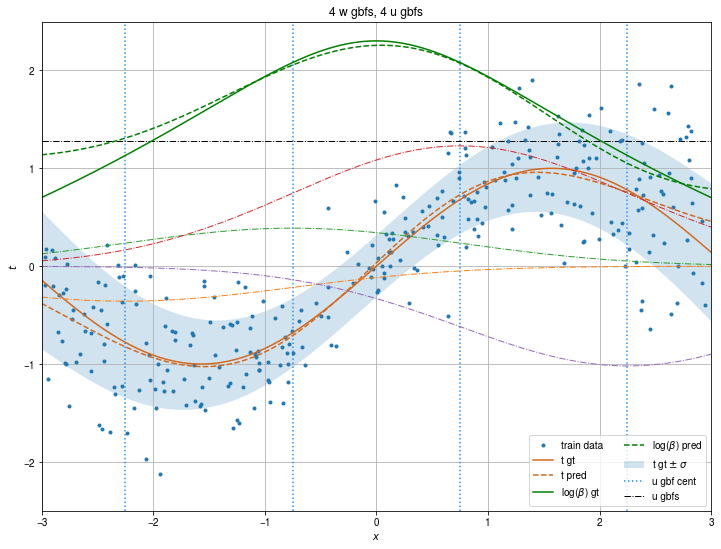

In [9]:
def plot_result_with_gbf(t_vals, t_vals_plot, var_vals_plot, loginvvar_vals_plot,
                         w_means, u_means, t_gbfs, loginvvar_gbfs,
                         t_gbfs_total, var_gbfs_total, loginvvar_gbfs_total):
  fig, ax = plt.subplots(figsize=(12, 9))

  # plot range
  xmin, xmax = -3.0, 3.0
  ymin, ymax = -2.5, 2.5

  # training data
  ax.plot(X, t_vals, '.', label='train data')
  # t ground truth and prediction
  ax.plot(Xcont, t_vals_plot, label='t gt', color='chocolate')
  ax.plot(Xcont, t_gbfs_total, '--', label='t pred', color='chocolate')
  # log(invvar) gt and prediction
  ax.plot(Xcont, loginvvar_vals_plot, label=r'log($\beta$) gt', color='green')
  ax.plot(Xcont, loginvvar_gbfs_total, '--', label=r'log($\beta$) pred', color='green')

  # shaded t gt +/- 1 stddev gt
  ax.fill_between(Xcont, t_vals_plot + X_stddev_cont, t_vals_plot - X_stddev_cont,
                  alpha=0.2, label='t gt $\pm$ $\sigma$')

  # # t gbf bias factor
  # ax.hlines(w_means[0], xmin, xmax, linestyles=':', label='w gbfs', color='grey')
  # # all the scaled t gbfs
  # for i in range(len(t_gbfs)):
  #   ax.plot(Xcont, w_means[i+1] * t_gbfs[i], ':', color='grey')

  # centers of u gbfs
  ax.vlines(mus_u, ymin, ymax, linestyles=':', color='dodgerblue', label='u gbf cent')
  # u gbf bias factor
  ax.hlines(u_means[0], xmin, xmax, linestyles='-.', linewidth=1, label='u gbfs')
  # all the scaled loginvvar gbfs
  for i in range(1, loginvvar_gbfs.shape[1]):
    ax.plot(Xcont, u_means[i] * loginvvar_gbfs[:, i], '-.', linewidth=1)

  tit = str(len(w_means)-1) + ' w gbfs, ' + str(len(u_means)-1) + ' u gbfs'
  ax.set(title=tit, xlabel=r'$x$', ylabel=r'$t$', xlim=(xmin, xmax), ylim=(ymin, ymax))
  ax.grid()
  ax.legend(ncol=2)

plot_result_with_gbf(t, tcont, X_var_cont, X_loginvvar_cont,
                     w_weights, u_weights, t_gbfs, loginvvar_gbfs,
                     t_gbfs_total, var_gbfs_total, loginvvar_gbfs_total)